In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from lightgbm import LGBMClassifier, LGBMRegressor

from sklearn.model_selection import train_test_split, cross_val_predict

pd.set_option('display.max_columns', 8)

# Causal Metrics Refresher

In [2]:
n = 20000
n_features = 10
treatment_p = 0.5

np.random.seed(123)

teh_features  = np.random.normal(0, 1, (n, n_features))
pred_features = np.random.normal(0, 1, (n, n_features))

teh_coef  = np.random.uniform(-1, 1, n_features)
pred_coef = np.random.uniform(-1, 1, n_features)
ate_bias  = 1

t = np.random.binomial(1, treatment_p, n)

y = np.random.normal(
    ate_bias*t
    + teh_features.dot(teh_coef)*t 
    + pred_features.dot(pred_coef)
)


df = pd.concat([
    pd.DataFrame(dict(y=y, t=t)),
    pd.DataFrame(teh_features, columns = [f"teh_{i}" for i in range(n_features)]),
    pd.DataFrame(pred_features, columns = [f"pred_{i}" for i in range(n_features)]),
], axis=1)


df.head()

,y,t,teh_0,teh_1,...,pred_6,pred_7,pred_8,pred_9
0,5.853318,1,-1.085631,0.997345,...,-1.211890,-0.758870,-0.856166,0.062708
1,1.755905,0,-0.678886,-0.094709,...,0.641869,-0.219113,1.680639,0.065926
2,2.508584,1,0.737369,1.490732,...,0.425951,0.770544,-1.724024,0.457547
3,0.116989,0,-0.255619,-2.798589,...,-0.131698,1.193299,1.926180,-0.328024
4,-0.452261,0,-0.805367,-1.727669,...,-1.414251,-0.370072,-0.724456,-0.518750


In [3]:
train, test = train_test_split(df, test_size=0.3, random_state=1)
train.shape, test.shape

((14000, 22), (6000, 22))

In [4]:
ate_train = train.query("t==1")["y"].mean() - train.query("t==0")["y"].mean()
ate_test = test.query("t==1")["y"].mean() - test.query("t==0")["y"].mean()
ate_train, ate_test 

(1.0238937821301746, 0.9843286169124309)

In [5]:
def dml_model(train_df,
              model_y,
              model_t,
              model_cate,
              X_cols,
              T_col, 
              Y_col):
    
    
    train_res = train_df.assign(t_res =  train_df[T_col] - cross_val_predict(model_t, train_df[X_cols], train_df[T_col], cv=5, method="predict_proba")[:, 1],
                                y_res =  train_df[Y_col] - cross_val_predict(model_y, train_df[X_cols], train_df[Y_col], cv=5))
    
    
    w = train_res["t_res"] ** 2  
    y_star = (train_res["y_res"] / train_res["t_res"])
    
    
    model_cate.fit(X=train_df[X_cols], y=y_star, sample_weight=w)
    return model_cate

In [6]:
X_cols =  train.drop(columns=["y", "t"]).columns


model_cate = dml_model(train,
                       model_t=LGBMClassifier(max_depth=3),
                       model_y=LGBMRegressor(max_depth=3),
                       model_cate=LGBMRegressor(max_depth=3),
                       X_cols=X_cols,
                       T_col="t",
                       Y_col="y")


pred_model = LGBMRegressor(max_depth=3).fit(train[X_cols], train["y"])

<AxesSubplot:>

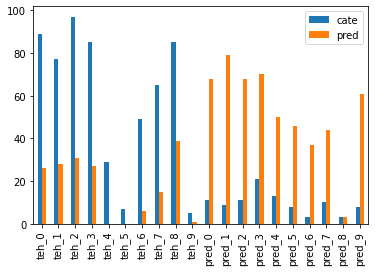

In [7]:
(pd.DataFrame(dict(cate=model_cate.feature_importances_, pred=pred_model.feature_importances_),
              index=model_cate.feature_name_)
 .plot.bar())

In [8]:
test_pred = test.assign(
    cate_pred = model_cate.predict(test[X_cols]),
    y_pred = pred_model.predict(test[X_cols])
)

cate_pred_band
(-5.332000000000001, -0.919]   -1.964935
(-0.919, -0.238]               -0.630314
(-0.238, 0.228]                -0.171287
(0.228, 0.603]                  0.179530
(0.603, 0.989]                  0.972066
(0.989, 1.368]                  1.126710
(1.368, 1.795]                  1.400051
(1.795, 2.28]                   1.995610
(2.28, 2.955]                   2.714577
(2.955, 6.759]                  4.181803
dtype: float64


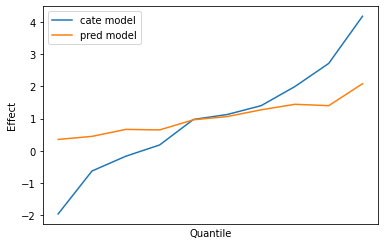

In [9]:
from fklearn.causal.validation.curves import effect_by_segment, cumulative_effect_curve, cumulative_gain_curve

cate_pred = effect_by_segment(
    df = test_pred,
    treatment = "t",
    outcome = "y",
    prediction = "cate_pred",
    segments = 10,
)

pred_effect_curve = effect_by_segment(
    df = test_pred,
    treatment = "t",
    outcome = "y",
    prediction = "y_pred",
    segments = 10,
)

print(cate_pred)

cate_pred.plot(label="cate model")
pred_effect_curve.plot(label="pred model")

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.xlabel("Quantile")
plt.ylabel("Effect")

plt.legend();

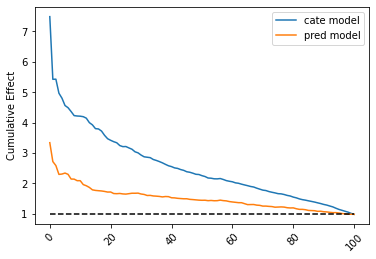

In [10]:
cumulative_cate_curve = cumulative_effect_curve(
    df = test_pred,
    treatment = "t",
    outcome = "y",
    prediction = "cate_pred",
)

pred_cumulative_cate_curve = cumulative_effect_curve(
    df = test_pred,
    treatment = "t",
    outcome = "y",
    prediction = "y_pred",
)


plt.plot(cumulative_cate_curve, label="cate model")
plt.plot(pred_cumulative_cate_curve, label="pred model")
plt.hlines(ate_test, 0, 100, color="0", ls="dashed")

plt.xticks(rotation=45)
plt.ylabel("Cumulative Effect")
plt.legend();

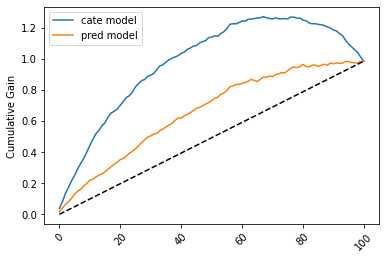

In [11]:
cumulative_gain = cumulative_gain_curve(
    df = test_pred,
    treatment = "t",
    outcome = "y",
    prediction = "cate_pred",
)

cumulative_gain_pred = cumulative_gain_curve(
    df = test_pred,
    treatment = "t",
    outcome = "y",
    prediction = "y_pred",
)


plt.plot(cumulative_gain, label="cate model")
plt.plot(cumulative_gain_pred, label="pred model")
plt.plot([0, 100], [0, ate_test], color="0", ls="dashed")

plt.xticks(rotation=45)
plt.ylabel("Cumulative Gain")
plt.legend();

# Causal Metrics and Binary Outcomes

In [12]:
n = 20000
n_features = 10
treatment_p = 0.5

np.random.seed(123)

teh_features  = np.random.normal(0, 1, (n, n_features))
pred_features = np.random.normal(0, 1, (n, n_features))

teh_coef  = np.random.uniform(-1, 1, n_features)
pred_coef = np.random.uniform(-1, 1, n_features)
ate_bias  = 1

t = np.random.binomial(1, treatment_p, n)

y = np.random.normal(
    ate_bias*t
    + teh_features.dot(teh_coef)*t 
    + pred_features.dot(pred_coef)
) 


df_low_p = pd.concat([
    pd.DataFrame(dict(y=(y>4)*1, t=t)),
    pd.DataFrame(teh_features, columns = [f"teh_{i}" for i in range(n_features)]),
    pd.DataFrame(pred_features, columns = [f"pred_{i}" for i in range(n_features)]),
], axis=1)


df_high_p = pd.concat([
    pd.DataFrame(dict(y=(y>-1)*1, t=t)),
    pd.DataFrame(teh_features, columns = [f"teh_{i}" for i in range(n_features)]),
    pd.DataFrame(pred_features, columns = [f"pred_{i}" for i in range(n_features)]),
], axis=1)


print(df_low_p["y"].mean(), df_high_p["y"].mean())

0.09485 0.71215


## Low Y Probability

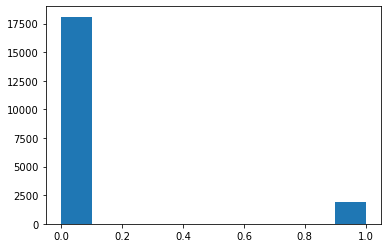

In [13]:
plt.hist(df_low_p["y"]);

In [14]:
train, test = train_test_split(df_low_p, test_size=0.3, random_state=1)
train.shape, test.shape

((14000, 22), (6000, 22))

In [15]:
ate_train = train.query("t==1")["y"].mean() - train.query("t==0")["y"].mean()
ate_test = test.query("t==1")["y"].mean() - train.query("t==0")["y"].mean()
ate_train, ate_test 

(0.10522119689903342, 0.11544210618988132)

In [16]:
def dml_model(train_df,
              model_y,
              model_t,
              model_cate,
              X_cols,
              T_col, 
              Y_col):
    
    
    train_res = train_df.assign(t_res =  train_df[T_col] - cross_val_predict(model_t, train_df[X_cols], train_df[T_col], cv=5, method="predict_proba")[:, 1],
                                y_res =  train_df[Y_col] - cross_val_predict(model_y, train_df[X_cols], train_df[Y_col], cv=5, method="predict_proba")[:, 1])
    
    
    w = train_res["t_res"] ** 2  
    y_star = (train_res["y_res"] / train_res["t_res"])
    
    
    model_cate.fit(X=train_df[X_cols], y=y_star, sample_weight=w)
    return model_cate

In [17]:
X_cols =  train.drop(columns=["y", "t"]).columns


model_cate = dml_model(train,
                       model_t=LGBMClassifier(max_depth=3),
                       model_y=LGBMClassifier(max_depth=3),
                       model_cate=LGBMRegressor(max_depth=3),
                       X_cols=X_cols,
                       T_col="t",
                       Y_col="y")


pred_model = LGBMClassifier(max_depth=3).fit(train[X_cols], train["y"])

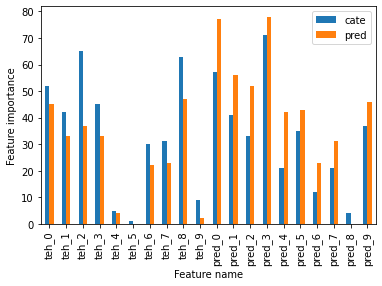

In [18]:
(pd.DataFrame(dict(cate=model_cate.feature_importances_, pred=pred_model.feature_importances_),
              index=model_cate.feature_name_)
 .plot.bar())
plt.ylabel("Feature importance");
plt.xlabel("Feature name");

In [19]:
test_pred = test.assign(
    cate_pred = model_cate.predict(test[X_cols]),
    y_pred = pred_model.predict_proba(test[X_cols])[:, 1]
)

ate_test = test_pred.query("t==1")["y"].mean() - test_pred.query("t==0")["y"].mean()

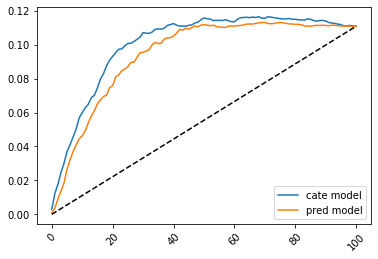

In [20]:
cumulative_gain = cumulative_gain_curve(
    df = test_pred,
    treatment = "t",
    outcome = "y",
    prediction = "cate_pred",
)

cumulative_gain_pred = cumulative_gain_curve(
    df = test_pred,
    treatment = "t",
    outcome = "y",
    prediction = "y_pred",
)


plt.plot(cumulative_gain, label="cate model")
plt.plot(cumulative_gain_pred, label="pred model")
plt.plot([0, 100], [0, ate_test], color="0", ls="dashed")

plt.xticks(rotation=45);
plt.legend();

## High Y Probability

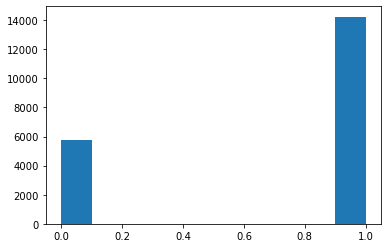

In [21]:
plt.hist(df_high_p["y"]);

In [22]:
train, test = train_test_split(df_high_p, test_size=0.3, random_state=1)
train.shape, test.shape

((14000, 22), (6000, 22))

In [23]:
ate_train = train.query("t==1")["y"].mean() - train.query("t==0")["y"].mean()
ate_test = test.query("t==1")["y"].mean() - train.query("t==0")["y"].mean()
ate_train, ate_test 

(0.09276212825843666, 0.09290362340069314)

In [24]:
X_cols =  train.drop(columns=["y", "t"]).columns


model_cate = dml_model(train,
                       model_t=LGBMClassifier(max_depth=3),
                       model_y=LGBMClassifier(max_depth=3),
                       model_cate=LGBMRegressor(max_depth=3),
                       X_cols=X_cols,
                       T_col="t",
                       Y_col="y")


pred_model = LGBMClassifier(max_depth=3).fit(train[X_cols], train["y"])

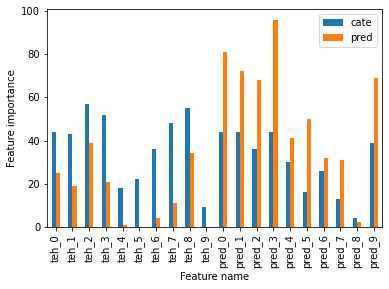

In [25]:
(pd.DataFrame(dict(cate=model_cate.feature_importances_, pred=pred_model.feature_importances_),
              index=model_cate.feature_name_)
 .plot.bar())
plt.ylabel("Feature importance");
plt.xlabel("Feature name");

In [26]:
test_pred = test.assign(
    cate_pred = model_cate.predict(test[X_cols]),
    y_pred = pred_model.predict_proba(test[X_cols])[:, 1],
    y_pred_rev = pred_model.predict_proba(test[X_cols])[:, 0],
)

ate_test = test_pred.query("t==1")["y"].mean() - test_pred.query("t==0")["y"].mean()

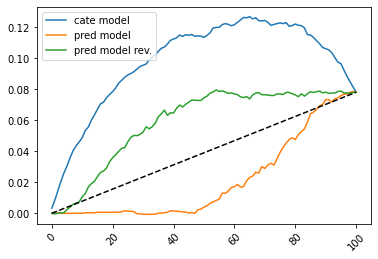

In [27]:
cumulative_gain = cumulative_gain_curve(
    df = test_pred,
    treatment = "t",
    outcome = "y",
    prediction = "cate_pred",
)

cumulative_gain_pred = cumulative_gain_curve(
    df = test_pred,
    treatment = "t",
    outcome = "y",
    prediction = "y_pred",
)

cumulative_gain_rev = cumulative_gain_curve(
    df = test_pred,
    treatment = "t",
    outcome = "y",
    prediction = "y_pred_rev",
)


plt.plot(cumulative_gain, label="cate model")
plt.plot(cumulative_gain_pred, label="pred model")
plt.plot(cumulative_gain_rev, label="pred model rev.")
plt.plot([0, 100], [0, ate_test], color="0", ls="dashed")

plt.xticks(rotation=45);
plt.legend();

# Causal Metrics and Continuous Treatments

In [28]:
n = 20000
n_features = 10
treatment_p = 0.5

np.random.seed(123)

teh_features  = np.random.normal(0, 1, (n, n_features))
pred_features = np.random.normal(0, 1, (n, n_features))

teh_coef  = np.random.uniform(-1, 1, n_features)
pred_coef = np.random.uniform(-1, 1, n_features)
ate_bias  = 1

t = np.random.binomial(1, treatment_p, n)

y = np.random.normal(
    ate_bias*t
    + teh_features.dot(teh_coef)*t 
    + pred_features.dot(pred_coef)
)


df = pd.concat([
    pd.DataFrame(dict(y=y, t=t)),
    pd.DataFrame(teh_features, columns = [f"teh_{i}" for i in range(n_features)]),
    pd.DataFrame(pred_features, columns = [f"pred_{i}" for i in range(n_features)]),
], axis=1)

In [29]:
n = 20000
n_features = 10
treatment_p = 0.5

np.random.seed(123)

teh_features  = np.random.normal(0, 1, (n, n_features))
pred_features = np.random.normal(0, 1, (n, n_features))

teh_coef  = np.random.uniform(-1, 1, n_features)
pred_coef = np.random.uniform(-1, 1, n_features)
ate_bias  = 1

t = np.random.normal(0, 1, n)

y = np.random.normal(
    ate_bias*t
    + teh_features.dot(teh_coef)*t 
    + pred_features.dot(pred_coef)
) 


df_cont = pd.concat([
    pd.DataFrame(dict(y=y, t=t)),
    pd.DataFrame(teh_features, columns = [f"teh_{i}" for i in range(n_features)]),
    pd.DataFrame(pred_features, columns = [f"pred_{i}" for i in range(n_features)]),
], axis=1)


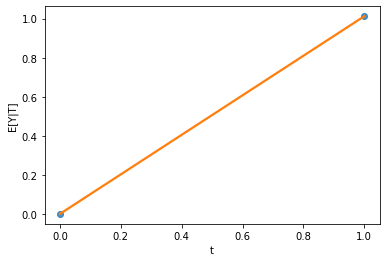

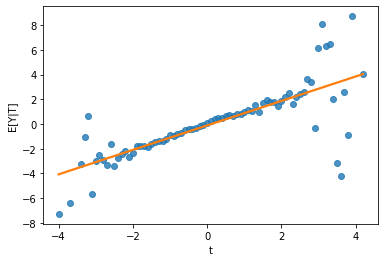

In [30]:
sns.regplot(x="t", y="y", data=df.groupby("t")[["y"]].mean().reset_index(), line_kws={"color": "C1"}, ci=False)
plt.ylabel("E[Y|T]")
plt.show()

sns.regplot(x="t", y="y",
            data=df_cont.round({"t":1}).groupby("t")[["y"]].mean().reset_index(),
            line_kws={"color": "C1"}, ci=False)
plt.ylabel("E[Y|T]");

In [31]:
train, test = train_test_split(df_cont, test_size=0.3, random_state=1)
train.shape, test.shape

((14000, 22), (6000, 22))

In [32]:
def dml_model(train_df,
              model_y,
              model_t,
              model_cate,
              X_cols,
              T_col, 
              Y_col):
    
    
    train_res = train_df.assign(t_res =  train_df[T_col] - cross_val_predict(model_t, train_df[X_cols], train_df[T_col], cv=5),
                                y_res =  train_df[Y_col] - cross_val_predict(model_y, train_df[X_cols], train_df[Y_col], cv=5))
    
    
    w = train_res["t_res"] ** 2  
    y_star = (train_res["y_res"] / train_res["t_res"])
    
    
    model_cate.fit(X=train_df[X_cols], y=y_star, sample_weight=w)
    return model_cate

In [33]:
X_cols =  train.drop(columns=["y", "t"]).columns


model_cate = dml_model(train,
                       model_t=LGBMRegressor(max_depth=3),
                       model_y=LGBMRegressor(max_depth=3),
                       model_cate=LGBMRegressor(max_depth=3),
                       X_cols=X_cols,
                       T_col="t",
                       Y_col="y")


pred_model = LGBMRegressor(max_depth=3).fit(train[X_cols], train["y"])

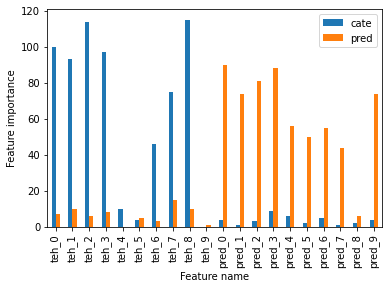

In [34]:
(pd.DataFrame(dict(cate=model_cate.feature_importances_, pred=pred_model.feature_importances_),
              index=model_cate.feature_name_)
 .plot.bar())
plt.ylabel("Feature importance");
plt.xlabel("Feature name");

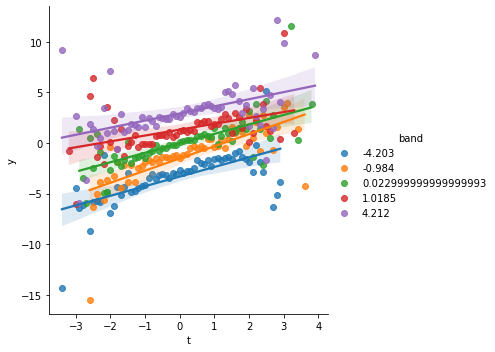

In [35]:
train_pred = (test
              .assign(pred = lambda d: pred_model.predict(d[X_cols]))
              .assign(band = lambda d: pd.IntervalIndex(pd.qcut(d["pred"], 5)).mid))

sns.lmplot(data=train_pred.round({"t":1}).groupby(["t", "band"])[["y"]].mean().reset_index(),
           x="t", y="y", hue="band")

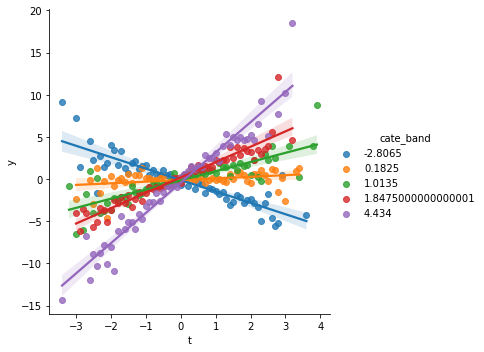

In [36]:
train_pred = (test
              .assign(cate_pred = lambda d: model_cate.predict(d[X_cols]))
              .assign(cate_band = lambda d: pd.IntervalIndex(pd.qcut(d["cate_pred"], 5)).mid))

sns.lmplot(data=train_pred.round({"t":1}).groupby(["t", "cate_band"])[["y"]].mean().reset_index(),
           x="t", y="y", hue="cate_band")

In [37]:
from fklearn.causal.effects import linear_effect

test_pred = test.assign(
    cate_pred = model_cate.predict(test[X_cols]),
    y_pred = pred_model.predict(test[X_cols]),
)

ate_test = linear_effect(test, "t", "y")
ate_test

0.9267314561881571

In [38]:
test_pred[["cate_pred", "y_pred", "y"]].corr()

,cate_pred,y_pred,y
cate_pred,1.000000,-0.003021,0.011007
y_pred,-0.003021,1.000000,0.672430
y,0.011007,0.672430,1.000000


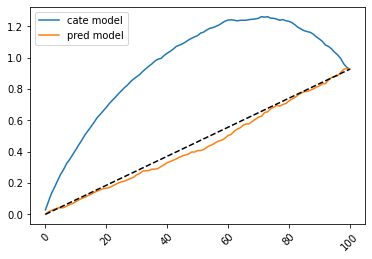

In [39]:
cumulative_gain = cumulative_gain_curve(
    df = test_pred,
    treatment = "t",
    outcome = "y",
    prediction = "cate_pred",
)

cumulative_gain_pred = cumulative_gain_curve(
    df = test_pred,
    treatment = "t",
    outcome = "y",
    prediction = "y_pred",
)


plt.plot(cumulative_gain, label="cate model")
plt.plot(cumulative_gain_pred, label="pred model")
plt.plot([0, 100], [0, ate_test], color="0", ls="dashed")

plt.xticks(rotation=45);
plt.legend();

# Non Linear Response Functions

In [40]:
n = 400000
n_features = 10

np.random.seed(123)

teh_features  = np.random.normal(0, 1, (n, n_features))
pred_features = np.random.normal(0, 1, (n, n_features))

teh_coef  = np.random.uniform(-1, 1, n_features)
pred_coef = np.random.uniform(-1, 1, n_features)
ate_bias  = 1

t = np.random.uniform(100, 5000, n)

y = np.random.normal(
    ate_bias*np.log(t)
    + teh_features.dot(teh_coef)*np.log(t)
    + pred_features.dot(pred_coef)*np.log(t).mean()
) 


df_cont = pd.concat([
    pd.DataFrame(dict(y=y, t=t)),
    pd.DataFrame(teh_features, columns = [f"teh_{i}" for i in range(n_features)]),
    pd.DataFrame(pred_features, columns = [f"pred_{i}" for i in range(n_features)]),
], axis=1)


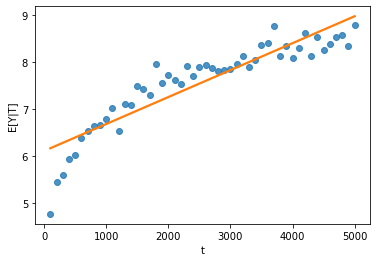

In [41]:
sns.regplot(x="t", y="y",
            data=df_cont.round({"t":-2}).groupby("t")[["y"]].mean().reset_index(),
            line_kws={"color": "C1"}, ci=False)
plt.ylabel("E[Y|T]");

In [42]:
train, test = train_test_split(df_cont, test_size=0.3, random_state=1)
train.shape, test.shape

((280000, 22), (120000, 22))

In [43]:
def dml_model(train_df,
              model_y,
              model_t,
              model_cate,
              X_cols,
              T_col, 
              Y_col):
    
    
    train_res = train_df.assign(t_res =  train_df[T_col] - cross_val_predict(model_t, train_df[X_cols], train_df[T_col], cv=5),
                                y_res =  train_df[Y_col] - cross_val_predict(model_y, train_df[X_cols], train_df[Y_col], cv=5))
    
    
    w = train_res["t_res"] ** 2  
    y_star = (train_res["y_res"] / train_res["t_res"])
    
    
    model_cate.fit(X=train_df[X_cols], y=y_star, sample_weight=w)
    return model_cate

In [44]:
X_cols =  train.drop(columns=["y", "t"]).columns


model_cate = dml_model(train,
                       model_t=LGBMRegressor(max_depth=3),
                       model_y=LGBMRegressor(max_depth=3),
                       model_cate=LGBMRegressor(max_depth=3),
                       X_cols=X_cols,
                       T_col="t",
                       Y_col="y")


pred_model = LGBMRegressor(max_depth=3).fit(train[X_cols], train["y"])

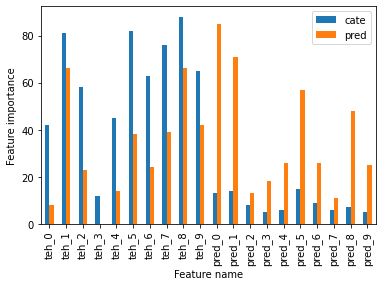

In [45]:
(pd.DataFrame(dict(cate=model_cate.feature_importances_, pred=pred_model.feature_importances_),
              index=model_cate.feature_name_)
 .plot.bar())
plt.ylabel("Feature importance");
plt.xlabel("Feature name");

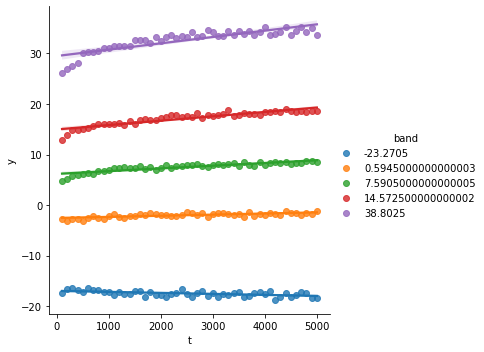

In [46]:
train_pred = (test
              .assign(pred = lambda d: pred_model.predict(d[X_cols]))
              .assign(band = lambda d: pd.IntervalIndex(pd.qcut(d["pred"], 5)).mid))

sns.lmplot(data=train_pred.round({"t":-2}).groupby(["t", "band"])[["y"]].mean().reset_index(),
           x="t", y="y", hue="band")

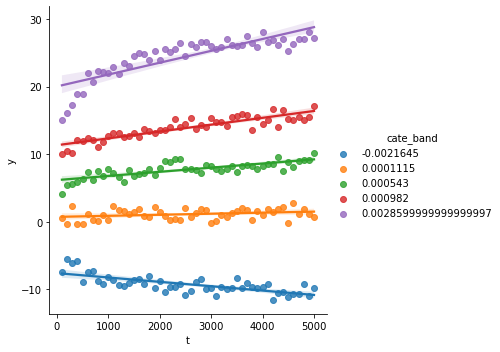

In [47]:
train_pred = (test
              .assign(cate_pred = lambda d: model_cate.predict(d[X_cols]))
              .assign(cate_band = lambda d: pd.IntervalIndex(pd.qcut(d["cate_pred"], 5)).mid))

sns.lmplot(data=train_pred.round({"t":-2}).groupby(["t", "cate_band"])[["y"]].mean().reset_index(),
           x="t", y="y", hue="cate_band")

In [48]:
from fklearn.causal.effects import linear_effect

test_pred = test.assign(
    cate_pred = model_cate.predict(test[X_cols]),
    y_pred = pred_model.predict(test[X_cols]),
)

ate_test = linear_effect(test, "t", "y")
ate_test

0.0005708462005449152

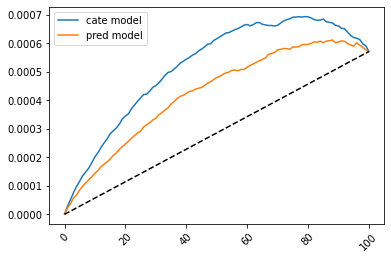

In [49]:
cumulative_gain = cumulative_gain_curve(
    df = test_pred,
    treatment = "t",
    outcome = "y",
    prediction = "cate_pred",
)

cumulative_gain_pred = cumulative_gain_curve(
    df = test_pred,
    treatment = "t",
    outcome = "y",
    prediction = "y_pred",
)


plt.plot(cumulative_gain, label="cate model")
plt.plot(cumulative_gain_pred, label="pred model")
plt.plot([0, 100], [0, ate_test], color="0", ls="dashed")

plt.xticks(rotation=45);
plt.legend();

## Adding Treatment Bands

In [50]:
n = 400000
n_features = 10

np.random.seed(123)

teh_features  = np.random.normal(0, 1, (n, n_features))
pred_features = np.random.normal(0, 1, (n, n_features))

teh_coef  = np.random.uniform(-1, 1, n_features)
pred_coef = np.random.uniform(-1, 1, n_features)
ate_bias  = 1

t = np.random.uniform(100, 5000, n)

y = np.random.normal(
    ate_bias*np.log(t)
    + teh_features.dot(teh_coef)*np.log(t)
    + pred_features.dot(pred_coef)*np.log(t).mean()
) 


df_cont = pd.concat([
    pd.DataFrame(dict(y=y, t=t)),
    pd.DataFrame(teh_features, columns = [f"teh_{i}" for i in range(n_features)]),
    pd.DataFrame(pred_features, columns = [f"pred_{i}" for i in range(n_features)]),
], axis=1)


In [51]:
t_bands = [500, 1000, 2000, 4000]

df_cont["t_bands"] = np.select([df_cont["t"] < x for x in t_bands], t_bands)

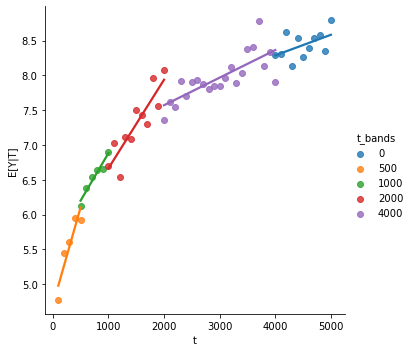

In [52]:
sns.lmplot(x="t", y="y", hue="t_bands",
            data=df_cont.round({"t":-2}).groupby(["t", "t_bands"])[["y"]].mean().reset_index(),
             ci=False)
plt.ylabel("E[Y|T]");

In [53]:
train, test = train_test_split(df_cont, test_size=0.3, random_state=1)
train.shape, test.shape

((280000, 23), (120000, 23))

In [54]:
X_cols =  train.drop(columns=["y", "t"]).columns


model_cate = dml_model(train,
                       model_t=LGBMRegressor(max_depth=3),
                       model_y=LGBMRegressor(max_depth=3),
                       model_cate=LGBMRegressor(max_depth=3),
                       X_cols=X_cols,
                       T_col="t",
                       Y_col="y")


pred_model = LGBMRegressor(max_depth=3).fit(train[X_cols], train["y"])

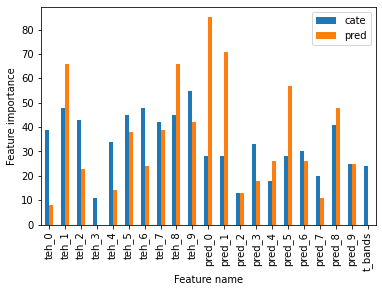

In [55]:
(pd.DataFrame(dict(cate=model_cate.feature_importances_, pred=pred_model.feature_importances_),
              index=model_cate.feature_name_)
 .plot.bar())
plt.ylabel("Feature importance");
plt.xlabel("Feature name");

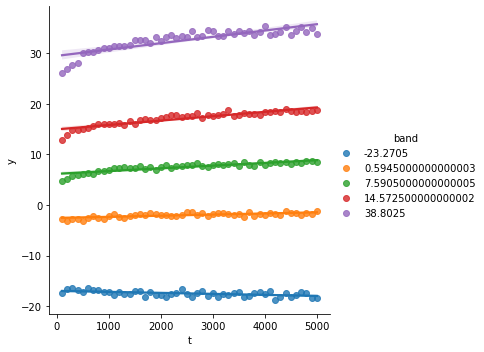

In [56]:
train_pred = (test
              .assign(pred = lambda d: pred_model.predict(d[X_cols]))
              .assign(band = lambda d: pd.IntervalIndex(pd.qcut(d["pred"], 5)).mid))

sns.lmplot(data=train_pred.round({"t":-2}).groupby(["t", "band"])[["y"]].mean().reset_index(),
           x="t", y="y", hue="band")

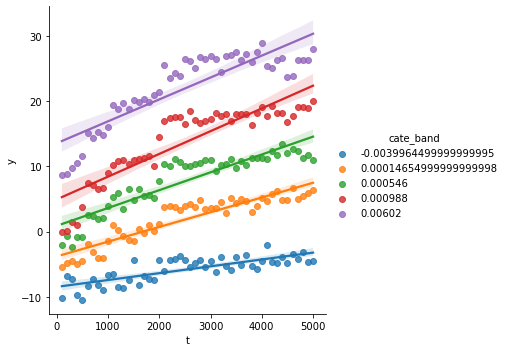

In [57]:
train_pred = (test
              .assign(cate_pred = lambda d: model_cate.predict(d[X_cols]))
              .assign(cate_band = lambda d: pd.IntervalIndex(pd.qcut(d["cate_pred"], 5)).mid))

sns.lmplot(data=train_pred.round({"t":-2}).assign(size=1).groupby(["t", "cate_band"]).agg({"size":"sum", "y":"mean"}).reset_index(),
           x="t", y="y", hue="cate_band")

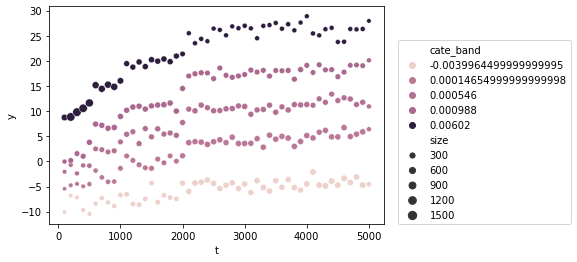

In [58]:
train_pred = (test
              .assign(cate_pred = lambda d: model_cate.predict(d[X_cols]))
              .assign(cate_band = lambda d: pd.IntervalIndex(pd.qcut(d["cate_pred"], 5)).mid))

sns.scatterplot(data=train_pred.round({"t":-2}).assign(size=1).groupby(["t", "cate_band"]).agg({"size":"sum", "y":"mean"}).reset_index(),
           x="t", y="y", hue="cate_band", size="size")
plt.legend(loc=(1.04, 0))

In [59]:
from fklearn.causal.effects import linear_effect

test_pred = test.assign(
    cate_pred = model_cate.predict(test[X_cols]),
    y_pred = pred_model.predict(test[X_cols]),
)

ate_test = linear_effect(test, "t", "y")
ate_test

0.0005708462005449152

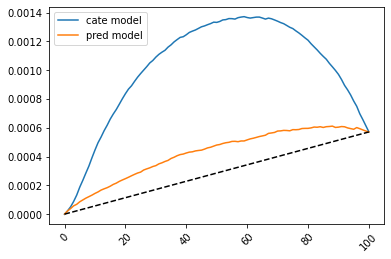

In [60]:
cumulative_gain = cumulative_gain_curve(
    df = test_pred,
    treatment = "t",
    outcome = "y",
    prediction = "cate_pred",
)

cumulative_gain_pred = cumulative_gain_curve(
    df = test_pred,
    treatment = "t",
    outcome = "y",
    prediction = "y_pred",
)


plt.plot(cumulative_gain, label="cate model")
plt.plot(cumulative_gain_pred, label="pred model")
plt.plot([0, 100], [0, ate_test], color="0", ls="dashed")

plt.xticks(rotation=45);
plt.legend();

## Linearizing The Treatment

In [61]:
n = 400000
n_features = 10

np.random.seed(123)

teh_features  = np.random.normal(0, 1, (n, n_features))
pred_features = np.random.normal(0, 1, (n, n_features))

teh_coef  = np.random.uniform(-1, 1, n_features)
pred_coef = np.random.uniform(-1, 1, n_features)
ate_bias  = 1

t = np.random.uniform(100, 5000, n)

y = np.random.normal(
    ate_bias*np.log(t)
    + teh_features.dot(teh_coef)*np.log(t)
    + pred_features.dot(pred_coef)*np.log(t).mean()
) 


df_cont = pd.concat([
    pd.DataFrame(dict(y=y, t=t)),
    pd.DataFrame(teh_features, columns = [f"teh_{i}" for i in range(n_features)]),
    pd.DataFrame(pred_features, columns = [f"pred_{i}" for i in range(n_features)]),
], axis=1)


In [62]:
df_cont = (df_cont
           .assign(log_t = np.log(df_cont["t"]))
           .drop(columns=["t"])
          )

df_cont.head()

,y,teh_0,teh_1,teh_2,...,pred_7,pred_8,pred_9,log_t
0,-12.646718,-1.085631,0.997345,0.282978,...,0.933313,-1.428870,-0.556806,7.561939
1,14.273006,-0.678886,-0.094709,1.491390,...,-1.052870,2.644569,0.602364,4.659109
2,5.298009,0.737369,1.490732,-0.935834,...,-0.244749,1.211831,-0.752576,8.423830
3,19.190482,-0.255619,-2.798589,-1.771533,...,0.290711,0.482445,1.386240,4.740136
4,-14.102476,-0.805367,-1.727669,-0.390900,...,-1.695403,1.700619,-2.602775,7.913950


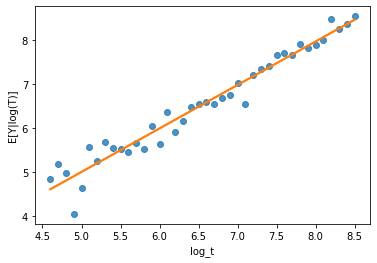

In [63]:
sns.regplot(x="log_t", y="y",
            data=df_cont.round({"log_t":1}).groupby("log_t")[["y"]].mean().reset_index(),
            line_kws={"color": "C1"}, ci=False)
plt.ylabel("E[Y|log(T)]");

In [64]:
train, test = train_test_split(df_cont, test_size=0.3, random_state=1)
train.shape, test.shape

((280000, 22), (120000, 22))

In [65]:
X_cols =  train.drop(columns=["y", "log_t"]).columns


model_cate = dml_model(train,
                       model_t=LGBMRegressor(max_depth=3),
                       model_y=LGBMRegressor(max_depth=3),
                       model_cate=LGBMRegressor(max_depth=3),
                       X_cols=X_cols,
                       T_col="log_t",
                       Y_col="y")


pred_model = LGBMRegressor(max_depth=3).fit(train[X_cols], train["y"])

In [66]:
X_cols

Index(['teh_0', 'teh_1', 'teh_2', 'teh_3', 'teh_4', 'teh_5', 'teh_6', 'teh_7',
       'teh_8', 'teh_9', 'pred_0', 'pred_1', 'pred_2', 'pred_3', 'pred_4',
       'pred_5', 'pred_6', 'pred_7', 'pred_8', 'pred_9'],
      dtype='object')

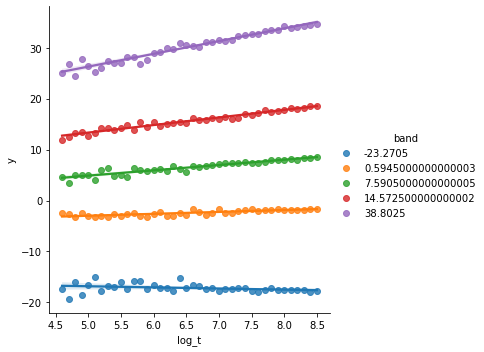

In [67]:
train_pred = (test
              .assign(pred = lambda d: pred_model.predict(d[X_cols]))
              .assign(band = lambda d: pd.IntervalIndex(pd.qcut(d["pred"], 5)).mid))

sns.lmplot(data=train_pred.round({"log_t":1}).groupby(["log_t", "band"])[["y"]].mean().reset_index(),
           x="log_t", y="y", hue="band")

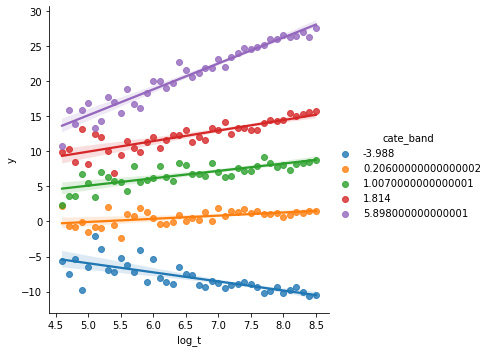

In [68]:
train_pred = (test
              .assign(cate_pred = lambda d: model_cate.predict(d[X_cols]))
              .assign(cate_band = lambda d: pd.IntervalIndex(pd.qcut(d["cate_pred"], 5)).mid))

sns.lmplot(data=train_pred.round({"log_t":1}).assign(size=1).groupby(["log_t", "cate_band"]).agg({"size":"sum", "y":"mean"}).reset_index(),
           x="log_t", y="y", hue="cate_band")

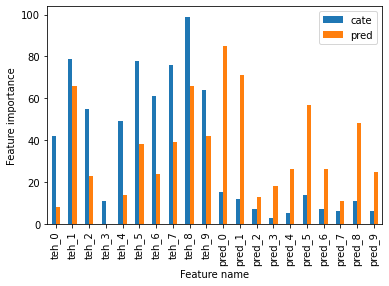

In [69]:
(pd.DataFrame(dict(cate=model_cate.feature_importances_, pred=pred_model.feature_importances_),
              index=model_cate.feature_name_)
 .plot.bar())
plt.ylabel("Feature importance");
plt.xlabel("Feature name");

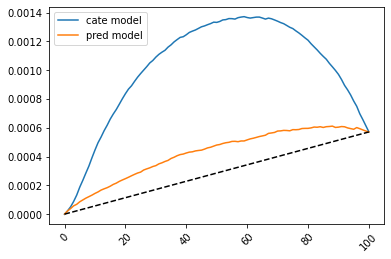

In [70]:
cumulative_gain = cumulative_gain_curve(
    df = test_pred,
    treatment = "t",
    outcome = "y",
    prediction = "cate_pred",
)

cumulative_gain_pred = cumulative_gain_curve(
    df = test_pred,
    treatment = "t",
    outcome = "y",
    prediction = "y_pred",
)


plt.plot(cumulative_gain, label="cate model")
plt.plot(cumulative_gain_pred, label="pred model")
plt.plot([0, 100], [0, ate_test], color="0", ls="dashed")

plt.xticks(rotation=45);
plt.legend();

## Bias Messing you Up

$$
T \sim B(0.5)\\
y \sim N(T + \pmb{\theta}X_{teh}T + \pmb{\beta}X_{pred})
$$

$$
T \sim N(-\pmb{\beta}X_{pred}) > 0\\
y \sim N(T + \pmb{\theta}X_{teh}T + \pmb{\beta}X_{pred})
$$

In [71]:
n = 20000
n_features = 10
treatment_p = 0.5

np.random.seed(123)

teh_features  = np.random.normal(0, 1, (n, n_features))
pred_features = np.random.normal(0, 1, (n, n_features))

teh_coef  = np.random.uniform(-1, 1, n_features)
pred_coef = np.random.uniform(-1, 1, n_features)
ate_bias  = 1

t_coef = np.random.uniform(-1, 1, n_features)


t = (np.random.normal(pred_features.dot(-pred_coef), 2) > 0)*1


y = np.random.normal(
    ate_bias*t
    + teh_features.dot(teh_coef)*t 
    + pred_features.dot(pred_coef)
)


df = pd.concat([
    pd.DataFrame(dict(y=y, t=t)),
    pd.DataFrame(teh_features, columns = [f"teh_{i}" for i in range(n_features)]),
    pd.DataFrame(pred_features, columns = [f"pred_{i}" for i in range(n_features)]),
], axis=1)


df.head()

,y,t,teh_0,teh_1,...,pred_6,pred_7,pred_8,pred_9
0,4.077867,1,-1.085631,0.997345,...,-1.211890,-0.758870,-0.856166,0.062708
1,6.696721,1,-0.678886,-0.094709,...,0.641869,-0.219113,1.680639,0.065926
2,0.740631,0,0.737369,1.490732,...,0.425951,0.770544,-1.724024,0.457547
3,-3.869968,1,-0.255619,-2.798589,...,-0.131698,1.193299,1.926180,-0.328024
4,2.377149,1,-0.805367,-1.727669,...,-1.414251,-0.370072,-0.724456,-0.518750


In [72]:
n = 20000
n_features = 10
treatment_p = 0.5

np.random.seed(123)


t = np.random.binomial(1, treatment_p, n)

y = np.random.normal(
    ate_bias*t
    + teh_features.dot(teh_coef)*t 
    + pred_features.dot(pred_coef)
)


df_rnd = pd.concat([
    pd.DataFrame(dict(y=y, t=t)),
    pd.DataFrame(teh_features, columns = [f"teh_{i}" for i in range(n_features)]),
    pd.DataFrame(pred_features, columns = [f"pred_{i}" for i in range(n_features)]),
], axis=1)


df_rnd.head()

,y,t,teh_0,teh_1,...,pred_6,pred_7,pred_8,pred_9
0,4.616856,1,-1.085631,0.997345,...,-1.211890,-0.758870,-0.856166,0.062708
1,0.365862,0,-0.678886,-0.094709,...,0.641869,-0.219113,1.680639,0.065926
2,2.993472,0,0.737369,1.490732,...,0.425951,0.770544,-1.724024,0.457547
3,-3.291799,1,-0.255619,-2.798589,...,-0.131698,1.193299,1.926180,-0.328024
4,2.703067,1,-0.805367,-1.727669,...,-1.414251,-0.370072,-0.724456,-0.518750


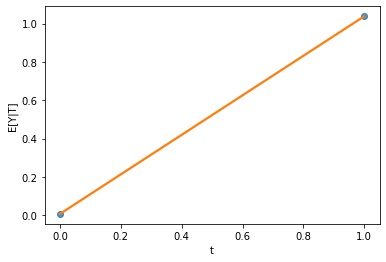

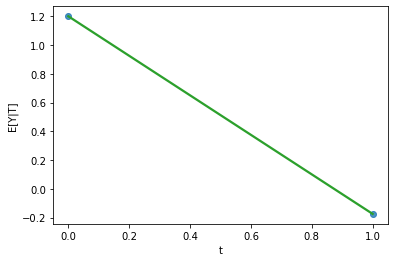

In [86]:
sns.regplot(x="t", y="y", data=df_rnd.groupby("t")[["y"]].mean().reset_index(), line_kws={"color": "C1"}, ci=False)
plt.ylabel("E[Y|T]")
plt.show()

sns.regplot(x="t", y="y", data=df.groupby("t")[["y"]].mean().reset_index(), line_kws={"color": "C2"}, ci=False)
plt.ylabel("E[Y|T]")
plt.show()


In [73]:
train, test = train_test_split(df, test_size=0.3, random_state=1)
train.shape, test.shape

((14000, 22), (6000, 22))

In [74]:
X_cols =  train.drop(columns=["y", "t"]).columns


model_cate = dml_model(train,
                       model_t=LGBMClassifier(max_depth=3),
                       model_y=LGBMRegressor(max_depth=3),
                       model_cate=LGBMRegressor(max_depth=3),
                       X_cols=X_cols,
                       T_col="t",
                       Y_col="y")


pred_model = LGBMRegressor(max_depth=3).fit(train[X_cols], train["y"])

<AxesSubplot:>

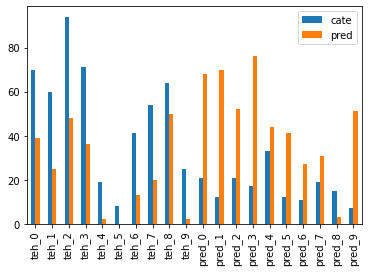

In [75]:
(pd.DataFrame(dict(cate=model_cate.feature_importances_, pred=pred_model.feature_importances_),
              index=model_cate.feature_name_)
 .plot.bar())

In [76]:
test_pred = test.assign(
    cate_pred = model_cate.predict(test[X_cols]),
    y_pred = pred_model.predict(test[X_cols])
)

In [77]:
bias_ate_train = train.query("t==1")["y"].mean() - train.query("t==0")["y"].mean()
bias_ate_test = test.query("t==1")["y"].mean() - test.query("t==0")["y"].mean()
bias_ate_train, bias_ate_test 

(-1.3845120682777412, -1.3523976418946313)

In [78]:
df_rnd_pred = df_rnd.assign(
    cate_pred = model_cate.predict(df_rnd[X_cols]),
    y_pred = pred_model.predict(df_rnd[X_cols])
)

In [79]:
rnd_ate = df_rnd.query("t==1")["y"].mean() - df_rnd.query("t==0")["y"].mean()
rnd_ate

1.031278707423352

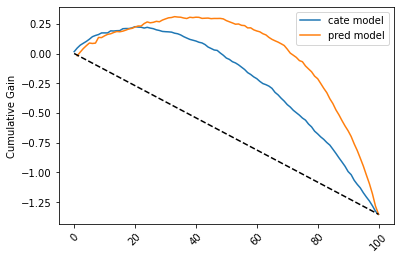

In [82]:
cumulative_gain = cumulative_gain_curve(
    df = test_pred,
    treatment = "t",
    outcome = "y",
    prediction = "cate_pred",
)

cumulative_gain_pred = cumulative_gain_curve(
    df = test_pred,
    treatment = "t",
    outcome = "y",
    prediction = "y_pred",
)


plt.plot(cumulative_gain, label="cate model")
plt.plot(cumulative_gain_pred, label="pred model")
plt.plot([0, 100], [0, bias_ate_test], color="0", ls="dashed")

plt.xticks(rotation=45)
plt.ylabel("Cumulative Gain")
plt.legend();

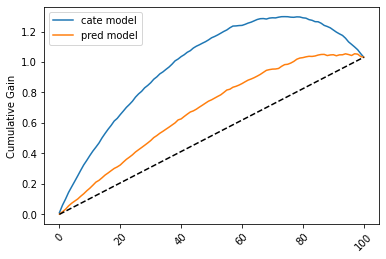

In [81]:
cumulative_gain = cumulative_gain_curve(
    df = df_rnd_pred,
    treatment = "t",
    outcome = "y",
    prediction = "cate_pred",
)

cumulative_gain_pred = cumulative_gain_curve(
    df = df_rnd_pred,
    treatment = "t",
    outcome = "y",
    prediction = "y_pred",
)


plt.plot(cumulative_gain, label="cate model")
plt.plot(cumulative_gain_pred, label="pred model")
plt.plot([0, 100], [0, rnd_ate], color="0", ls="dashed")

plt.xticks(rotation=45)
plt.ylabel("Cumulative Gain")
plt.legend();